![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# Click-Through Rate Prediction Notebook
This notebook covers the steps for creating a click-through rate (CTR) prediction pipeline.  We will work with the [Criteo Labs](http://labs.criteo.com/) dataset that was used for a recent [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge).

** This notebook will cover: **

* *Part 1:* Featurize categorical data using one-hot-encoding (OHE)

* *Part 2:* Construct an OHE dictionary

* *Part 3:* Parse CTR data and generate OHE features
 * *Visualization 1:* Feature frequency

* *Part 4:* CTR prediction and logloss evaluation
 * *Visualization 2:* ROC curve

* *Part 5:* Reduce feature dimension via feature hashing

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [PySpark's DataFrame API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.DataFrame)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

In [4]:
from databricks_test_helper import Test

## Part 1: Featurize categorical data using one-hot-encoding

### (1a) One-hot-encoding

We would like to develop code to convert categorical features to numerical ones, and to build intuition, we will work with a sample unlabeled dataset with three data points, with each data point representing an animal. The first feature indicates the type of animal (bear, cat, mouse); the second feature describes the animal's color (black, tabby); and the third (optional) feature describes what the animal eats (mouse, salmon).

In a one-hot-encoding (OHE) scheme, we want to represent each tuple of `(featureID, category)` via its own binary feature.  We can do this in Python by creating a dictionary that maps each tuple to a distinct integer, where the integer corresponds to a binary feature. To start, manually enter the entries in the OHE dictionary associated with the sample dataset by mapping the tuples to consecutive integers starting from zero,  ordering the tuples first by featureID and next by category.

Later in this notebook, we'll use OHE dictionaries to transform data points into compact lists of features that can be used in machine learning algorithms.

In [7]:
# By default, when a shuffle operation occurs with DataFrames, the post-shuffle partition
# count is 200. This is controlled by Spark configuration value spark.sql.shuffle.partitions.
# 200 is a little too high for this data set, so we set the post-shuffle partition count to
# twice the number of available threads in Community Edition.
sqlContext.setConf('spark.sql.shuffle.partitions', '6')  # Set default partitions for DataFrame operations

In [8]:
from collections import defaultdict
# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sample_one = [(0, 'mouse'), (1, 'black')]
sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

def sample_to_row(sample):
    tmp_dict = defaultdict(lambda: None)
    tmp_dict.update(sample)
    return [tmp_dict[i] for i in range(3)]

sqlContext.createDataFrame(map(sample_to_row, [sample_one, sample_two, sample_three]),
                           ['animal', 'color', 'food']).show()
sample_data_df = sqlContext.createDataFrame([(sample_one,), (sample_two,), (sample_three,)], ['features'])
sample_data_df.show(truncate=False)

+------+-----+------+
animal|color| food|
+------+-----+------+
 mouse|black| null|
 cat|tabby| mouse|
 bear|black|salmon|
+------+-----+------+

+---------------------------------+
features |
+---------------------------------+
[[0,mouse], [1,black]] |
[[0,cat], [1,tabby], [2,mouse]] |
[[0,bear], [1,black], [2,salmon]]|
+---------------------------------+

In [9]:
# TODO: Replace <FILL IN> with appropriate code
sample_ohe_dict_manual = {}
sample_ohe_dict_manual[(0, 'bear')] = 0
sample_ohe_dict_manual[(0, 'cat')] = 1
sample_ohe_dict_manual[(0, 'mouse')] = 2
sample_ohe_dict_manual[(1, 'black')] = 3
sample_ohe_dict_manual[(1, 'tabby')] = 4
sample_ohe_dict_manual[(1, 'black')] = 3
sample_ohe_dict_manual[(2, 'mouse')] = 5
sample_ohe_dict_manual[(2, 'salmon')] = 6

In [10]:
# TEST One-hot-encoding (1a)
Test.assertEqualsHashed(sample_ohe_dict_manual[(0, 'bear')],
                        'b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
                        "incorrect value for sample_ohe_dict_manual[(0,'bear')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(0, 'cat')],
                        '356a192b7913b04c54574d18c28d46e6395428ab',
                        "incorrect value for sample_ohe_dict_manual[(0,'cat')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(0, 'mouse')],
                        'da4b9237bacccdf19c0760cab7aec4a8359010b0',
                        "incorrect value for sample_ohe_dict_manual[(0,'mouse')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(1, 'black')],
                        '77de68daecd823babbb58edb1c8e14d7106e83bb',
                        "incorrect value for sample_ohe_dict_manual[(1,'black')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(1, 'tabby')],
                        '1b6453892473a467d07372d45eb05abc2031647a',
                        "incorrect value for sample_ohe_dict_manual[(1,'tabby')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(2, 'mouse')],
                        'ac3478d69a3c81fa62e60f5c3696165a4e5e6ac4',
                        "incorrect value for sample_ohe_dict_manual[(2,'mouse')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(2, 'salmon')],
                        'c1dfd96eea8cc2b62785275bca38ac261256e278',
                        "incorrect value for sample_ohe_dict_manual[(2,'salmon')]")
Test.assertEquals(len(sample_ohe_dict_manual.keys()), 7,
                  'incorrect number of keys in sample_ohe_dict_manual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.

### (1b) Sparse vectors

Data points can typically be represented with a small number of non-zero OHE features relative to the total number of features that occur in the dataset.  By leveraging this sparsity and using sparse vector representations for OHE data, we can reduce storage and computational burdens.  Below are a few sample vectors represented as dense numpy arrays.  Use [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) to represent them in a sparse fashion, and verify that both the sparse and dense representations yield the same results when computing [dot products](http://en.wikipedia.org/wiki/Dot_product) (we will later use MLlib to train classifiers via gradient descent, and MLlib will need to compute dot products between SparseVectors and dense parameter vectors).

Use `SparseVector(size, *args)` to create a new sparse vector where size is the length of the vector and args is either:
1. A list of indices and a list of values corresponding to the indices. The indices list must be sorted in ascending order. For example, SparseVector(5, [1, 3, 4], [10, 30, 40]) will represent the vector [0, 10, 0, 30, 40]. The non-zero indices are 1, 3 and 4. On the other hand, SparseVector(3, [2, 1], [5, 5]) will give you an error because the indices list [2, 1] is not in ascending order. Note: you cannot simply sort the indices list, because otherwise the values will not correspond to the respective indices anymore.
2. A list of (index, value) pair. In this case, the indices need not be sorted. For example, SparseVector(5, [(3, 1), (1, 2)]) will give you the vector [0, 2, 0, 1, 0].

SparseVectors are much more efficient when working with sparse data because they do not store zero values (only store non-zero values and their indices). You'll need to create a sparse vector representation of each dense vector `a_dense` and `b_dense`.

In [12]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

In [13]:
# TODO: Replace <FILL IN> with appropriate code
a_dense = np.array([0., 3., 0., 4.])
a_sparse = SparseVector(4, [1, 3], [3, 4])

b_dense = np.array([0., 0., 0., 1.])
b_sparse = SparseVector(4, [3], [1])

w = np.array([0.4, 3.1, -1.4, -.5])
print a_dense.dot(w)
print a_sparse.dot(w)
print b_dense.dot(w)
print b_sparse.dot(w)

7.3
7.3
-0.5
-0.5

In [14]:
# TEST Sparse Vectors (1b)
Test.assertTrue(isinstance(a_sparse, SparseVector), 'a_sparse needs to be an instance of SparseVector')
Test.assertTrue(isinstance(b_sparse, SparseVector), 'a_sparse needs to be an instance of SparseVector')
Test.assertTrue(a_dense.dot(w) == a_sparse.dot(w),
                'dot product of a_dense and w should equal dot product of a_sparse and w')
Test.assertTrue(b_dense.dot(w) == b_sparse.dot(w),
                'dot product of b_dense and w should equal dot product of b_sparse and w')
Test.assertTrue(a_sparse.numNonzeros() == 2, 'a_sparse should not store zero values')
Test.assertTrue(b_sparse.numNonzeros() == 1, 'b_sparse should not store zero values')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.

### (1c) OHE features as sparse vectors

Now let's see how we can represent the OHE features for points in our sample dataset.  Using the mapping defined by the OHE dictionary from Part (1a), manually define OHE features for the three sample data points using SparseVector format.  Any feature that occurs in a point should have the value 1.0.  For example, the `DenseVector` for a point with features 2 and 4 would be `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [16]:
# Reminder of the sample features
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [17]:
# TODO: Replace <FILL IN> with appropriate code
sample_one_ohe_feat_manual = SparseVector(7, [2, 3], [1,1])
sample_two_ohe_feat_manual = SparseVector(7, [1, 4,5], [1,1,1])
sample_three_ohe_feat_manual = SparseVector(7, [0,3,6], [1,1,1])

In [18]:
# TEST OHE Features as sparse vectors (1c)
Test.assertTrue(isinstance(sample_one_ohe_feat_manual, SparseVector),
                'sample_one_ohe_feat_manual needs to be a SparseVector')
Test.assertTrue(isinstance(sample_two_ohe_feat_manual, SparseVector),
                'sample_two_ohe_feat_manual needs to be a SparseVector')
Test.assertTrue(isinstance(sample_three_ohe_feat_manual, SparseVector),
                'sample_three_ohe_feat_manual needs to be a SparseVector')
Test.assertEqualsHashed(sample_one_ohe_feat_manual,
                        'ecc00223d141b7bd0913d52377cee2cf5783abd6',
                        'incorrect value for sample_one_ohe_feat_manual')
Test.assertEqualsHashed(sample_two_ohe_feat_manual,
                        '26b023f4109e3b8ab32241938e2e9b9e9d62720a',
                        'incorrect value for sample_two_ohe_feat_manual')
Test.assertEqualsHashed(sample_three_ohe_feat_manual,
                        'c04134fd603ae115395b29dcabe9d0c66fbdc8a7',
                        'incorrect value for sample_three_ohe_feat_manual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.

### (1d) Define a OHE function

Next we will use the OHE dictionary from Part (1a) to programatically generate OHE features from the original categorical data.  First write a function called `one_hot_encoding` that creates OHE feature vectors in `SparseVector` format.  Then use this function to create OHE features for the first sample data point and verify that the result matches the result from Part (1c).

> Note: We'll pass in the OHE dictionary as a [Broadcast](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.Broadcast) variable, which will greatly improve performance when we call this function as part of a UDF. **When accessing a broadcast variable, you _must_ use `.value`.** For instance: `ohe_dict_broadcast.value`.

In [20]:
# TODO: Replace <FILL IN> with appropriate code
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    raw_feats = sorted(raw_feats, key=lambda t:t[0])
    return SparseVector(num_ohe_feats, sorted(list(map(lambda t:ohe_dict_broadcast.value[t], raw_feats))), list(map(lambda t: 1, raw_feats)))

# Calculate the number of features in sample_ohe_dict_manual
num_sample_ohe_feats = len(sample_ohe_dict_manual)
sample_ohe_dict_manual_broadcast = sc.broadcast(sample_ohe_dict_manual)

# Run one_hot_encoding() on sample_one.  Make sure to pass in the Broadcast variable.
sample_one_ohe_feat = one_hot_encoding(sample_one, sample_ohe_dict_manual_broadcast, num_sample_ohe_feats)

print sample_one_ohe_feat

(7,[2,3],[1.0,1.0])

In [21]:
# TEST Define an OHE Function (1d)
Test.assertTrue(sample_one_ohe_feat == sample_one_ohe_feat_manual,
                'sample_one_ohe_feat should equal sample_one_ohe_feat_manual')
Test.assertEquals(sample_one_ohe_feat, SparseVector(7, [2, 3], [1.0, 1.0]),
                  'incorrect value for sample_one_ohe_feat')
Test.assertEquals(one_hot_encoding([(1, 'black'), (0, 'mouse')], sample_ohe_dict_manual_broadcast,
                                   num_sample_ohe_feats), SparseVector(7, [2, 3], [1.0, 1.0]),
                  'incorrect definition for one_hot_encoding')

1 test passed.
1 test passed.
1 test passed.

### (1e) Apply OHE to a dataset

Finally, use the function from Part (1d) to create OHE features for all 3 data points in the sample dataset.  You'll need to generate a [UDF](https://spark.apache.org/docs/1.6.1/api/python/pyspark.sql.html#pyspark.sql.functions.udf) that can be used in a `DataFrame` `select` statement.

> Note: Your implemenation of `ohe_udf_generator` needs to call your `one_hot_encoding` function.

In [23]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import VectorUDT

def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())

sample_ohe_dict_udf = ohe_udf_generator(sample_ohe_dict_manual_broadcast)
sample_ohe_df = sample_data_df.select(sample_ohe_dict_udf(sample_data_df.features))
sample_ohe_df.show(truncate=False)

+----------------------------+
PythonUDF#<lambda>(features)|
+----------------------------+
(7,[2,3],[1.0,1.0]) |
(7,[1,4,5],[1.0,1.0,1.0]) |
(7,[0,3,6],[1.0,1.0,1.0]) |
+----------------------------+

In [24]:
# TEST Apply OHE to a dataset (1e)
sample_ohe_data_values = sample_ohe_df.collect()
Test.assertTrue(len(sample_ohe_data_values) == 3, 'sample_ohe_data_values should have three elements')
Test.assertEquals(sample_ohe_data_values[0], (SparseVector(7, {2: 1.0, 3: 1.0}),),
                  'incorrect OHE for first sample')
Test.assertEquals(sample_ohe_data_values[1], (SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}),),
                  'incorrect OHE for second sample')
Test.assertEquals(sample_ohe_data_values[2], (SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0}),),
                  'incorrect OHE for third sample')
Test.assertTrue('one_hot_encoding' in sample_ohe_dict_udf.func.func_code.co_names,
                'ohe_udf_generator should call one_hot_encoding')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.

## Part 2: Construct an OHE dictionary

### (2a) DataFrame with rows of `(featureID, category)`

To start, create a DataFrame of distinct `(feature_id, category)` tuples. In our sample dataset, the 7 items in the resulting DataFrame are `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`. Notably `'black'` appears twice in the dataset but only contributes one item to the DataFrame: `(1, 'black')`, while `'mouse'` also appears twice and contributes two items: `(0, 'mouse')` and `(2, 'mouse')`.  Use [explode](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.explode) and [distinct](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.distinct).

In [27]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import explode
sample_distinct_feats_df = (sample_data_df.select(explode(sample_data_df.features))).distinct()
sample_distinct_feats_df.show()

+----------+
 col|
+----------+
 [0,bear]|
 [0,mouse]|
 [1,black]|
 [1,tabby]|
[2,salmon]|
 [2,mouse]|
 [0,cat]|
+----------+

In [28]:
# TEST DataFrame with rows of `(featureID, category)` (2a)
Test.assertEquals(sorted(map(lambda r: r[0], sample_distinct_feats_df.collect())),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'incorrect value for sample_distinct_feats_df')

1 test passed.

### (2b) OHE Dictionary from distinct features

Next, create an RDD of key-value tuples, where each `(feature_id, category)` tuple in `sample_distinct_feats_df` is a key and the values are distinct integers ranging from 0 to (number of keys - 1).  Then convert this RDD into a dictionary, which can be done using the `collectAsMap` action.  Note that there is no unique mapping from keys to values, as all we require is that each `(featureID, category)` key be mapped to a unique integer between 0 and the number of keys.  In this exercise, any valid mapping is acceptable.  Use [zipWithIndex](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) followed by [collectAsMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap).

In our sample dataset, one valid list of key-value tuples is: `[((0, 'bear'), 0), ((2, 'salmon'), 1), ((1, 'tabby'), 2), ((2, 'mouse'), 3), ((0, 'mouse'), 4), ((0, 'cat'), 5), ((1, 'black'), 6)]`. The dictionary defined in Part (1a) illustrates another valid mapping between keys and integers.

> Note: We provide the code to convert the DataFrame to an RDD.

In [30]:
# TODO: Replace <FILL IN> with appropriate code
sample_ohe_dict = (sample_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
print sample_ohe_dict

{(2, u'mouse'): 5, (0, u'cat'): 6, (0, u'bear'): 0, (2, u'salmon'): 4, (1, u'tabby'): 3, (1, u'black'): 2, (0, u'mouse'): 1}

In [31]:
# TEST OHE Dictionary from distinct features (2b)
Test.assertEquals(sorted(sample_ohe_dict.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sample_ohe_dict has unexpected keys')
Test.assertEquals(sorted(sample_ohe_dict.values()), range(7), 'sample_ohe_dict has unexpected values')

1 test passed.
1 test passed.

### (2c) Automated creation of an OHE dictionary

Now use the code from Parts (2a) and (2b) to write a function that takes an input dataset and outputs an OHE dictionary.  Then use this function to create an OHE dictionary for the sample dataset, and verify that it matches the dictionary from Part (2b).

In [33]:
# TODO: Replace <FILL IN> with appropriate code
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    distinct_df = (input_df.select(explode(input_df.features))).distinct()
    return (distinct_df.rdd.map(lambda r: tuple(r[0])).zipWithIndex().collectAsMap())
    
sample_ohe_dict_auto = create_one_hot_dict(sample_data_df)

In [34]:
# TEST Automated creation of an OHE dictionary (2c)
Test.assertEquals(sorted(sample_ohe_dict_auto.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sample_ohe_dict_auto has unexpected keys')
Test.assertEquals(sorted(sample_ohe_dict_auto.values()), range(7),
                  'sample_ohe_dict_auto has unexpected values')

1 test passed.
1 test passed.

## Part 3: Parse CTR data and generate OHE features

Before we can proceed, you'll first need to obtain the data from Criteo.  Here is the link to Criteo's data sharing agreement: <a href="http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/" target="criteo">http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/</a>.  After you accept the agreement, you can obtain the download URL by right-clicking on the "**Download Sample**" button and clicking "Copy link address" or "Copy Link Location", depending on your browser.

* Run the cell containing the `download_criteo()` function.
* Paste the URL into the `TODO` cell below that cell. Then, run the cell. It will download the data and make it available as a DataFrame, in variable `raw_df`.

Note that the download should complete within 30 seconds.

**WARNING: Be sure you get the "Download Sample" link, _not_ the "Download" link!**

In [37]:
# Nothing to edit here. Just run this cell.

def cleanup_old_downloads():
  from fnmatch import fnmatch

  # Clean up old downloaded files from dbfs:/tmp to prevent QUOTA_EXCEEDED errors.
  for f in dbutils.fs.ls('/tmp'):
    name = str(f.name)
    if fnmatch(name, 'criteo_*'):
      dbutils.fs.rm(str(f.path), recurse=True)

def download_criteo(url):
  from io import BytesIO
  import urllib2
  import tarfile
  import uuid
  import tempfile
  import random
  import string
  import os

  if not url.endswith('dac_sample.tar.gz'):
    raise Exception('Check your download URL. Are you downloading the sample dataset?')

  cleanup_old_downloads()

  # Create a random ID for the directory containing the downloaded file, to avoid any name clashes
  # with any other clusters. (Might not be necessary, but, safety first...)
  rng = random.SystemRandom()
  tlds = ('.org', '.net', '.com', '.info', '.biz')
  random_domain_name = (
    ''.join(rng.choice(string.letters + string.digits) for i in range(64)) +
    rng.choice(tlds)
  )
  random_id = str(uuid.uuid3(uuid.NAMESPACE_DNS, random_domain_name)).replace('-', '_')
  unique_id = str(uuid.uuid3(uuid.NAMESPACE_DNS, random_id)).replace('-', '_')
  dbfs_dir  = 'dbfs:/tmp/criteo_{0}'.format(unique_id)
  dbfs_path = '{0}/data.txt'.format(dbfs_dir)
  dbutils.fs.mkdirs(dbfs_dir)

  # Download the tarball and unpack it.
  tmp = BytesIO()
  req = urllib2.Request(url, headers={'User-Agent': 'Databricks'})
  url_handle = urllib2.urlopen(req)
  tmp.write(url_handle.read())
  tmp.seek(0)
  tf = tarfile.open(fileobj=tmp)
  dac_sample = tf.extractfile('dac_sample.txt')
  dac_sample = '\n'.join([unicode(x.replace('\n', '').replace('\t', ',')) for x in dac_sample])

  # Write the downloaded data to to dbfs:/tmp.
  with tempfile.NamedTemporaryFile(mode='wb', delete=False, prefix='dac', suffix='.txt') as t:
    t.write(dac_sample)
    t.close()
    dbutils.fs.cp('file://{0}'.format(t.name), dbfs_path)
    os.unlink(t.name)

  return dbfs_path

In [38]:
# TODO: Replace <FILL IN> with the appropriate URL. Then, run the following cell
# to download the data.
criteo_url = 'http://criteolabs.wpengine.com/wp-content/uploads/2015/04/dac_sample.tar.gz'

In [39]:
# Run this cell after you have filled in criteo_url.

if ('downloaded_data_file' not in locals()) or (downloaded_data_file is None):
  downloaded_data_file = download_criteo(criteo_url)

if ('raw_df' in locals()) and (raw_df is not None):
  print "raw_df is already loaded. Nothing to do. (Set raw_df=None to reload it, then re-run this cell.)"
else:
  raw_df = sqlContext.read.text(downloaded_data_file).withColumnRenamed("value", "text")

print "raw_df initialized to read from {0}".format(downloaded_data_file)

raw_df is already loaded. Nothing to do. (Set raw_df=None to reload it, then re-run this cell.)
raw_df initialized to read from dbfs:/tmp/criteo_8e94e086_8e2f_306a_9022_49487a0f34ad/data.txt

In [40]:
raw_df.show()

+--------------------+
 text|
+--------------------+
0,1,1,5,0,1382,4,...|
0,2,0,44,1,102,8,...|
0,2,0,1,14,767,89...|
0,,893,,,4392,,0,...|
0,3,-1,,0,2,0,3,0...|
0,,-1,,,12824,,0,...|
0,,1,2,,3168,,0,1...|
1,1,4,2,0,0,0,1,0...|
0,,44,4,8,19010,2...|
0,,35,,1,33737,21...|
0,,2,632,0,56770,...|
0,0,6,6,6,421,109...|
1,0,-1,,,1465,0,1...|
1,,2,11,5,10262,3...|
0,0,51,84,4,3633,...|
0,,2,1,18,20255,,...|
1,1,987,,2,105,2,...|
0,0,1,,0,16597,55...|
0,0,24,4,2,2056,1...|
0,7,102,,3,780,15...|
+--------------------+
only showing top 20 rows

### (3a) Loading and splitting the data

We are now ready to start working with the actual CTR data, and our first task involves splitting it into training, validation, and test sets.  Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) with the specified weights and seed to create DFs storing each of these datasets, and then [cache](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.cache) each of these DFs, as we will be accessing them multiple times in the remainder of this notebook. Finally, compute the size of each dataset.

In [42]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42

# Use randomSplit with weights and seed
raw_train_df, raw_validation_df, raw_test_df = raw_df.randomSplit(weights, seed)

# Cache and count the DataFrames
n_train = raw_train_df.cache().count()
n_val = raw_validation_df.cache().count()
n_test = raw_test_df.cache().count()
print n_train, n_val, n_test, n_train + n_val + n_test
raw_df.show(1)

80178 9887 9935 100000
+--------------------+
 text|
+--------------------+
0,1,1,5,0,1382,4,...|
+--------------------+
only showing top 1 row

In [43]:
# TEST Loading and splitting the data (3a)

Test.assertTrue(all([raw_train_df.is_cached, raw_validation_df.is_cached, raw_test_df.is_cached]),
                'you must cache the split data')
Test.assertEquals(n_train, 80178, 'incorrect value for n_train')
Test.assertEquals(n_val, 9887, 'incorrect value for n_val')
Test.assertEquals(n_test, 9935, 'incorrect value for n_test')

1 test passed.
1 test passed.
1 test passed.
1 test passed.

### (3b) Extract features

We will now parse the raw training data to create a DataFrame that we can subsequently use to create an OHE dictionary. Note from the `show()` command in Part (3a) that each raw data point is a string containing several fields separated by some delimiter.  For now, we will ignore the first field (which is the 0-1 label), and parse the remaining fields (or raw features).  To do this, complete the implemention of the `parse_point` function.

In [45]:
# TODO: Replace <FILL IN> with appropriate code
def parse_point(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    return [(i, x) for i,x in enumerate(point.split(",")[1:])]

print parse_point(raw_df.select('text').first()[0])

[(0, u'1'), (1, u'1'), (2, u'5'), (3, u'0'), (4, u'1382'), (5, u'4'), (6, u'15'), (7, u'2'), (8, u'181'), (9, u'1'), (10, u'2'), (11, u''), (12, u'2'), (13, u'68fd1e64'), (14, u'80e26c9b'), (15, u'fb936136'), (16, u'7b4723c4'), (17, u'25c83c98'), (18, u'7e0ccccf'), (19, u'de7995b8'), (20, u'1f89b562'), (21, u'a73ee510'), (22, u'a8cd5504'), (23, u'b2cb9c98'), (24, u'37c9c164'), (25, u'2824a5f6'), (26, u'1adce6ef'), (27, u'8ba8b39a'), (28, u'891b62e7'), (29, u'e5ba7672'), (30, u'f54016b9'), (31, u'21ddcdc9'), (32, u'b1252a9d'), (33, u'07b5194c'), (34, u''), (35, u'3a171ecb'), (36, u'c5c50484'), (37, u'e8b83407'), (38, u'9727dd16')]

In [46]:
# TEST Extract features (3b)
Test.assertEquals(parse_point(raw_df.select('text').first()[0])[:3], [(0, u'1'), (1, u'1'), (2, u'5')],
                  'incorrect implementation of parse_point')

1 test passed.

### (3c) Extracting features continued

Next, we'll create a `parse_raw_df` function that creates a `label` column from the first value in the text and a `feature` column from the rest of the values.  The `feature` column will be created using `parse_point_udf`, which we've provided and is based on your `parse_point` function.  Note that to name your columns you should use [alias](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.alias).  You can split the `text` field in `raw_df` using [split](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.split) and retrieve the first value of the resulting array with [getItem](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.getItem). Be sure to call [cast](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.cast) to cast the column value to `double`. Your `parse_raw_df` function should also cache the DataFrame it returns.

In [48]:
# TODO: Replace <FILL IN> with the appropriate code
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType

parse_point_udf = udf(parse_point, ArrayType(StructType([StructField('_1', LongType()),
                                                         StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and feature.


    Args:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.
    """
    return raw_df.select([split(raw_df.text, ",").getItem(0).cast('double').alias('label'), parse_point_udf(raw_df.text).alias('feature')])

# Parse the raw training DataFrame
parsed_train_df = parse_raw_df(raw_train_df).cache()

from pyspark.sql.functions import (explode, col)
num_categories = (parsed_train_df
                    .select(explode('feature').alias('feature'))
                    .distinct()
                    .select(col('feature').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

print num_categories[2][1]

1706

In [49]:
# TEST Extract features (3c)
Test.assertTrue(parsed_train_df.is_cached, 'parse_raw_df should return a cached DataFrame')
Test.assertEquals(num_categories[2][1], 1706, 'incorrect implementation of parse_point or parse_raw_df')
Test.assertEquals(num_categories[32][1], 128, 'incorrect implementation of parse_point or parse_raw_df')

1 test passed.
1 test passed.
1 test passed.

### (3d) Create an OHE dictionary from the dataset

Note that `parse_point` returns a data point as a list of `(featureID, category)` tuples, which is the same format as the sample dataset studied in Parts 1 and 2 of this notebook.  Using this observation, create an OHE dictionary from the parsed training data using the function implemented in Part (2c). Note that we will assume for simplicity that all features in our CTR dataset are categorical.

In [51]:
# TODO: Replace <FILL IN> with appropriate code
#(parsed_train_df.select(parsed_train_df.feature.alias("features"))).show()

ctr_ohe_dict = create_one_hot_dict((parsed_train_df.select(parsed_train_df.feature.alias("features"))))
num_ctr_ohe_feats = len(ctr_ohe_dict)#.count()
print num_ctr_ohe_feats
print ctr_ohe_dict[(0, '')]

233941
194837

In [52]:
# TEST Create an OHE dictionary from the dataset (3d)
Test.assertEquals(num_ctr_ohe_feats, 233941, 'incorrect number of features in ctr_ohe_dict')
Test.assertTrue((0, '') in ctr_ohe_dict, 'incorrect features in ctr_ohe_dict')

1 test passed.
1 test passed.

### (3e) Apply OHE to the dataset

Now let's use this OHE dictionary, by starting with the training data that we've parsed into `label` and `feature` columns, to create one-hot-encoded features.  Recall that we created a function `ohe_udf_generator` that can create the UDF that we need to convert row into `features`.  Make sure that `ohe_train_df` contains a `label` and `features` column and is cached.

In [54]:
# TODO: Replace <FILL IN> with the appropriate code
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf = ohe_udf_generator(ohe_dict_broadcast)

ohe_train_df = (parsed_train_df
                .select(parsed_train_df.label.alias("label"),
                        ohe_dict_udf(parsed_train_df.feature).alias("features"))).cache()

print ohe_train_df.count()
print ohe_train_df.take(1)

ohe_train_df.show()

80178
[Row(label=0.0, features=SparseVector(233941, {0: 1.0, 1: 1.0, 39036: 1.0, 39037: 1.0, 39038: 1.0, 39039: 1.0, 39040: 1.0, 39041: 1.0, 39042: 1.0, 39043: 1.0, 39044: 1.0, 39045: 1.0, 39046: 1.0, 39047: 1.0, 77792: 1.0, 77793: 1.0, 77794: 1.0, 77795: 1.0, 77796: 1.0, 77797: 1.0, 77798: 1.0, 116844: 1.0, 116845: 1.0, 116846: 1.0, 116847: 1.0, 155823: 1.0, 155824: 1.0, 155825: 1.0, 155826: 1.0, 155827: 1.0, 155828: 1.0, 155829: 1.0, 155830: 1.0, 194837: 1.0, 194838: 1.0, 194839: 1.0, 194840: 1.0, 194841: 1.0, 194842: 1.0}))]
+-----+--------------------+
label| features|
+-----+--------------------+
 0.0|(233941,[0,1,3903...|
 0.0|(233941,[2,3,4,39...|
 0.0|(233941,[5,6,3903...|
 0.0|(233941,[7,8,9,39...|
 0.0|(233941,[6,39036,...|
 0.0|(233941,[10,11,39...|
 0.0|(233941,[12,13,39...|
 0.0|(233941,[14,15,16...|
 0.0|(233941,[5,18,390...|
 0.0|(233941,[7,8,19,2...|
 0.0|(233941,[2,10,21,...|
 0.0|(233941,[22,39036...|
 0.0|(233941,[23,24,25...|
 0.0|(233941,[26,27,39...|
 0.0|(233941,[28,29,39...|
 0.0|(233941,[22,39036...|
 0.0|(233941,[11,39036...|
 0.0|(233941,[5,14,390...|
 0.0|(233941,[30,39036...|
 0.0|(233941,[11,39036...|
+-----+--------------------+
only showing top 20 rows

In [55]:
# TEST Apply OHE to the dataset (3e)
Test.assertTrue('label' in ohe_train_df.columns and 'features' in ohe_train_df.columns, 'ohe_train_df should have label and features columns')
Test.assertTrue(ohe_train_df.is_cached, 'ohe_train_df should be cached')
num_nz = sum(parsed_train_df.rdd.map(lambda r: len(r[1])).take(5))
num_nz_alt = sum(ohe_train_df.rdd.map(lambda r: len(r[1].indices)).take(5))
Test.assertEquals(num_nz, num_nz_alt, 'incorrect value for ohe_train_df')

1 test passed.
1 test passed.
1 test passed.

### Visualization 1: Feature frequency

We will now visualize the number of times each of the 233,941 OHE features appears in the training data. We first compute the number of times each feature appears, then bucket the features by these counts.  The buckets are sized by powers of 2, so the first bucket corresponds to features that appear exactly once ( \\( \scriptsize 2^0 \\) ), the second to features that appear twice ( \\( \scriptsize 2^1 \\) ), the third to features that occur between three and four ( \\( \scriptsize 2^2 \\) ) times, the fifth bucket is five to eight ( \\( \scriptsize 2^3 \\) ) times and so on. The scatter plot below shows the logarithm of the bucket thresholds versus the logarithm of the number of features that have counts that fall in the buckets.

In [57]:
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import log

get_indices = udf(lambda sv: map(int, sv.indices), ArrayType(IntegerType()))
feature_counts = (ohe_train_df
                   .select(explode(get_indices('features')))
                   .groupBy('col')
                   .count()
                   .withColumn('bucket', log('count').cast('int'))
                   .groupBy('bucket')
                   .count()
                   .orderBy('bucket')
                   .collect())

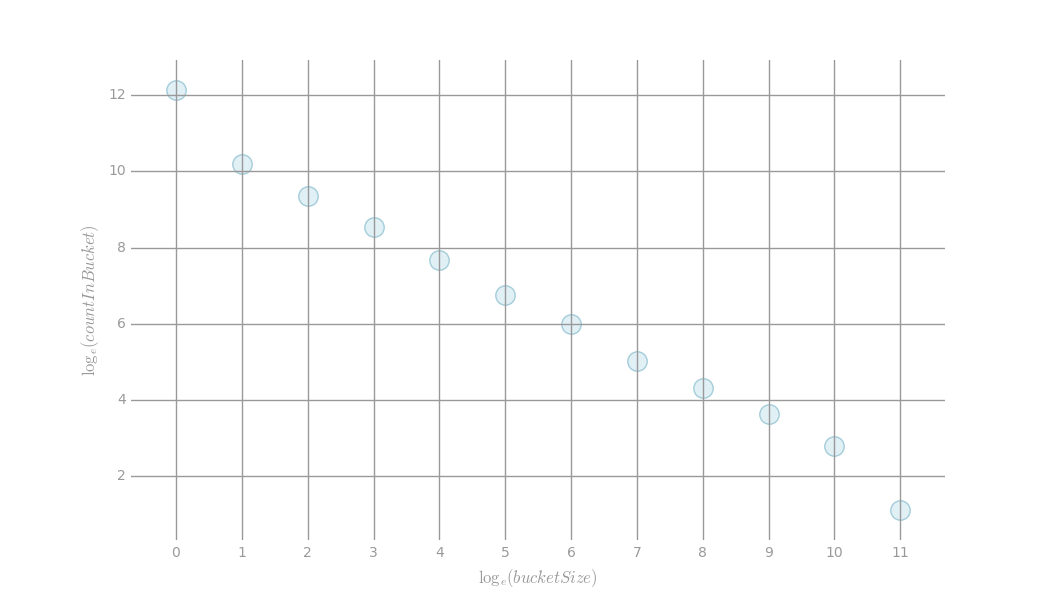

In [58]:
import matplotlib.pyplot as plt

x, y = zip(*feature_counts)
x, y = x, np.log(y)

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 12, 1), np.arange(0, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
display(fig)

### (3f) Handling unseen features

We naturally would like to repeat the process from Part (3e), to compute OHE features for the validation and test datasets.  However, we must be careful, as some categorical values will likely appear in new data that did not exist in the training data. To deal with this situation, update the `one_hot_encoding()` function from Part (1d) to ignore previously unseen categories, and then compute OHE features for the validation data.  Remember that you can parse a raw DataFrame using `parse_raw_df`.
> Note: you'll have to generate a new UDF using `ohe_udf_generator` so that the updated `one_hot_encoding` function is used.  And make sure to cache `ohe_validation_df`.

In [60]:
# TODO: Replace <FILL IN> with appropriate code
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    
    #filter_feats = []
    #for t in raw_feats:
    #  if t[0] in ohe_dict_broadcast.value.keys:
    #    filter_feats.append(t)
    
    #raw_feats = filter(lambda t:t[0] in ohe_dict_broadcast.value, raw_feats)
    raw_feats = sorted(raw_feats, key=lambda t:t[0])
    
    filter_feats = []
    for t in raw_feats:
      if t in ohe_dict_broadcast.value:
        filter_feats.append(ohe_dict_broadcast.value[t])
    
    return SparseVector(num_ohe_feats, sorted(filter_feats), list(map(lambda t: 1, filter_feats)))

ohe_dict_missing_udf = ohe_udf_generator(ohe_dict_broadcast)
parsed_validation_df = parse_raw_df(raw_validation_df).cache()
ohe_validation_df = (parsed_validation_df.select(parsed_validation_df.label.alias("label"),
                        ohe_dict_missing_udf(parsed_validation_df.feature).alias("features"))).cache()

parsed_test_df = parse_raw_df(raw_test_df).cache()
ohe_test_df = (parsed_validation_df.select(parsed_validation_df.label.alias("label"),
                        ohe_dict_missing_udf(parsed_validation_df.feature).alias("features"))).cache()

ohe_validation_df.count()
ohe_validation_df.show(1, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
label|features |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
0.0 |(233941,[0,1,11,39036,39037,39038,39039,39040,39041,39045,39046,39066,77792,77793,77794,77795,77796,77797,77798,98673,116844,116845,116846,116847,116849,116855,116856,155823,155824,155825,155826,155828,155830,155840,194837,194838,194839,194842,194846],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row

In [61]:
# TEST Handling unseen features (3f)
from pyspark.sql.functions import size, sum as sqlsum

Test.assertTrue(ohe_validation_df.is_cached, 'you need to cache ohe_validation_df')
num_nz_val = (ohe_validation_df
                .select(sqlsum(size(get_indices('features'))))
                .first()[0])

nz_expected = 365226
Test.assertEquals(num_nz_val, nz_expected, 'incorrect number of features: Got {0}, expected {1}'.format(num_nz_val, nz_expected))

1 test passed.
1 test passed.

## Part 4: CTR prediction and logloss evaluation

### (4a) Logistic regression

We are now ready to train our first CTR classifier.  A natural classifier to use in this setting is logistic regression, since it models the probability of a click-through event rather than returning a binary response, and when working with rare events, probabilistic predictions are useful.

First use [LogisticRegression](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) from the pyspark.ml package to train a model using `ohe_train_df` with the given hyperparameter configuration.  `LogisticRegression.fit` returns a [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegressionModel).  Next, we'll use the `LogisticRegressionModel.coefficients` and `LogisticRegressionModel.intercept` attributes to print out some details of the model's parameters.  Note that these are the names of the object's attributes and should be called using a syntax like `model.coefficients` for a given `model`.

In [64]:
# TODO: Replace <FILL IN> with appropriate code
standardization = False
elastic_net_param = 0.0
reg_param = .01
max_iter = 20

from pyspark.ml.classification import LogisticRegression
lr = (LogisticRegression(maxIter=max_iter, regParam=reg_param, elasticNetParam=elastic_net_param, standardization=standardization))

lr_model_basic = lr.fit(ohe_train_df)

print 'intercept: {0}'.format(lr_model_basic.intercept)
print 'length of coefficients: {0}'.format(len(lr_model_basic.coefficients))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]

intercept: -1.23057928975
length of coefficients: 233941

In [65]:
# TEST Logistic regression (4a)
Test.assertTrue(np.allclose(lr_model_basic.intercept,  -1.23057928975), 'incorrect value for model intercept')
Test.assertTrue(np.allclose(sorted_coefficients,
                           [-0.1187459897152528, -0.10978507583227733, -0.10927080243659906, -0.10854213952664242, -0.10715533859341671]),
                           'incorrect value for model coefficients')

1 test passed.
1 test passed.

### (4b) Log loss
Throughout this notebook, we will use log loss to evaluate the quality of models.  Log loss is defined as: \\[ \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \\] where \\( \scriptsize p\\) is a probability between 0 and 1 and \\( \scriptsize y\\) is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).

Write a function `add_log_loss` to a DataFrame, and evaluate it on some sample inputs.  This does not require a UDF.  You can perform conditional branching with DataFrame columns using [when](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.when).

In [67]:
# Some example data
example_log_loss_df = sqlContext.createDataFrame([(.5, 1), (.5, 0), (.99, 1), (.99, 0), (.01, 1),
                                                  (.01, 0), (1., 1), (.0, 1), (1., 0)], ['p', 'label'])
example_log_loss_df.show()

+----+-----+
 p|label|
+----+-----+
 0.5| 1|
 0.5| 0|
0.99| 1|
0.99| 0|
0.01| 1|
0.01| 0|
 1.0| 1|
 0.0| 1|
 1.0| 0|
+----+-----+

In [68]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import when, log, col
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
    """
    df = df.select([when(df.p == 0, df.p + epsilon).when(df.p == 1, df.p - epsilon).otherwise(df.p).alias("p"), df.label])
    return df.select([df.p, df.label, when(df.label == 1, -log(df.p)).otherwise(-log(1-df.p)).alias("log_loss")])

add_log_loss(example_log_loss_df).show()

+------------------+-----+--------------------+
 p|label| log_loss|
+------------------+-----+--------------------+
 0.5| 1| 0.6931471805599453|
 0.5| 0| 0.6931471805599453|
 0.99| 1| 0.01005033585350145|
 0.99| 0| 4.605170185988091|
 0.01| 1| 4.605170185988091|
 0.01| 0| 0.01005033585350145|
0.9999999999999999| 1|1.110223024625156...|
 1.0E-16| 1| 36.841361487904734|
0.9999999999999999| 0| 36.7368005696771|
+------------------+-----+--------------------+

In [69]:
# TEST Log loss (4b)
log_loss_values = add_log_loss(example_log_loss_df).select('log_loss').rdd.map(lambda r: r[0]).collect()
Test.assertTrue(np.allclose(log_loss_values[:-2],
                            [0.6931471805599451, 0.6931471805599451, 0.010050335853501338, 4.60517018598808,
                             4.605170185988081, 0.010050335853501338, -0.0]), 'log loss is not correct')
Test.assertTrue(not(any(map(lambda x: x is None, log_loss_values[-2:]))),
                'log loss needs to bound p away from 0 and 1 by epsilon')

1 test passed.
1 test passed.

### (4c)  Baseline log loss

Next we will use the function we wrote in Part (4b) to compute the baseline log loss on the training data. A very simple yet natural baseline model is one where we always make the same prediction independent of the given datapoint, setting the predicted value equal to the fraction of training points that correspond to click-through events (i.e., where the label is one). Compute this value (which is simply the mean of the training labels), and then use it to compute the training log loss for the baseline model.

> Note: you'll need to add a `p` column to the `ohe_train_df` DataFrame so that it can be used in your function from Part (4b).  To represent a constant value as a column you can use the [lit](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lit) function to wrap the value.

In [71]:
# TODO: Replace <FILL IN> with appropriate code
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower

from pyspark.sql.functions import lit
from pyspark.sql.functions import mean
#class_one_frac_train = ohe_train_df.select([ohe_train_df.label, ohe_train_df.features, lit(ohe_train_df.label).alias("p")])
class_one_frac_train = float(ohe_train_df.select(mean(ohe_train_df.label)).first()[0])
print 'Training class one fraction = {0:.3f}'.format(class_one_frac_train)

modified_train_df = ohe_train_df.select([ohe_train_df.label, ohe_train_df.features, lit(class_one_frac_train).alias("p")])

log_loss_df = add_log_loss(modified_train_df)
log_loss_tr_base = float(log_loss_df.select(mean(log_loss_df.log_loss)).first()[0])

print 'Baseline Train Logloss = {0:.3f}\n'.format(log_loss_tr_base)

Training class one fraction = 0.226
Baseline Train Logloss = 0.535

In [72]:
# TEST Baseline log loss (4c)
expected_frac = 0.226209184564
expected_log_loss = 0.53465512785
Test.assertTrue(np.allclose(class_one_frac_train, expected_frac), 'incorrect value for class_one_frac_train. Got {0}, expected {1}'.format(class_one_frac_train, expected_frac))
Test.assertTrue(np.allclose(log_loss_tr_base, expected_log_loss), 'incorrect value for log_loss_tr_base. Got {0}, expected {1}'.format(log_loss_tr_base, expected_log_loss))

1 test passed.
1 test passed.

### (4d) Predicted probability

In order to compute the log loss for the model we trained in Part (4a), we need to write code to generate predictions from this model. Write a function that computes the raw linear prediction from this logistic regression model and then passes it through a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) \\( \scriptsize \sigma(t) = (1+ e^{-t})^{-1} \\) to return the model's probabilistic prediction. Then compute probabilistic predictions on the training data.

Note that when incorporating an intercept into our predictions, we simply add the intercept to the value of the prediction obtained from the weights and features.  Alternatively, if the intercept was included as the first weight, we would need to add a corresponding feature to our data where the feature has the value one.  This is not the case here.

In [74]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

def add_probability(df, model):
    """Adds a probability column ('p') to a DataFrame given a model"""
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        """Calculate the probability for an observation given a list of features.

        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.

        Args:
            features: the features

        Returns:
            float: A probability between 0 and 1.
        """
        # Compute the raw value
        raw_prediction = intercept + features.dot(coefficients_broadcast.value)
        # Bound the raw value between 20 and -20
        raw_prediction = 20 if raw_prediction > 20 else -20 if raw_prediction < -20 else raw_prediction
        
        def sigmoid(x):
           return 1 / (1 + exp(-x))
        
        # Return the probability
        return sigmoid(raw_prediction)

    get_p_udf = udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))

add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_df).cache()

training_predictions.show(5)

+-----+--------------------+-------------------+
label| features| p|
+-----+--------------------+-------------------+
 0.0|(233941,[0,1,3903...| 0.1524569011902128|
 0.0|(233941,[2,3,4,39...|0.15116321092690524|
 0.0|(233941,[5,6,3903...|0.16569053420524252|
 0.0|(233941,[7,8,9,39...|0.12978985339524937|
 0.0|(233941,[6,39036,...| 0.1909081707983523|
+-----+--------------------+-------------------+
only showing top 5 rows

In [75]:
# TEST Predicted probability (4d)
expected = 18168.793778
got = training_predictions.selectExpr('sum(p)').first()[0]
Test.assertTrue(np.allclose(got, expected),
                'incorrect value for training_predictions. Got {0}, expected {1}'.format(got, expected))

1 test passed.

### (4e) Evaluate the model

We are now ready to evaluate the quality of the model we trained in Part (4a). To do this, first write a general function that takes as input a model and data, and outputs the log loss. Note that the log loss for multiple observations is the mean of the individual log loss values. Then run this function on the OHE training data, and compare the result with the baseline log loss.

In [77]:
# TODO: Replace <FILL IN> with appropriate code
def evaluate_results(df, model, baseline=None):
    """Calculates the log loss for the data given the model.

    Note:
        If baseline has a value the probability should be set to baseline before
        the log loss is calculated.  Otherwise, use add_probability to add the
        appropriate probabilities to the DataFrame.

    Args:
        df (DataFrame with 'label' and 'features' columns): A DataFrame containing
            labels and features.
        model (LogisticRegressionModel): A trained logistic regression model. This
            can be None if baseline is set.
        baseline (float): A baseline probability to use for the log loss calculation.

    Returns:
        float: Log loss for the data.
    """
    with_probability_df = None
    if model != None:
      with_probability_df = add_probability(df, model)
    else:
      with_probability_df = df.select([df.label, df.features, lit(baseline).alias("p")])
      
    with_log_loss_df = add_log_loss(with_probability_df)
    log_loss = float(with_log_loss_df.select(mean(with_log_loss_df.log_loss)).first()[0])
    return log_loss

log_loss_train_model_basic = evaluate_results(ohe_train_df, lr_model_basic)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_basic))

OHE Features Train Logloss:
	Baseline = 0.535
	LogReg = 0.475

In [78]:
# TEST Evaluate the model (4e)
expected_log_loss = 0.474685722542
Test.assertTrue(np.allclose(log_loss_train_model_basic, expected_log_loss),
                'incorrect value for log_loss_train_model_basic. Got {0}, expected {1}'.format(log_loss_train_model_basic, expected_log_loss))
expected_res = 0.6931471805600546
res = evaluate_results(ohe_train_df, None,  0.5)
Test.assertTrue(np.allclose(res, expected_res),
                'evaluate_results needs to handle baseline models. Got {0}, expected {1}'.format(res, expected_res))

1 test passed.
1 test passed.

### (4f) Validation log loss

Next, using the `evaluate_results` function compute the validation log loss for both the baseline and logistic regression models. Notably, the baseline model for the validation data should still be based on the label fraction from the training dataset.

In [80]:
# TODO: Replace <FILL IN> with appropriate code
#base = float(ohe_validation_df.select(mean(ohe_train_df.label)).first()[0])
log_loss_val_base = evaluate_results(ohe_validation_df, None, class_one_frac_train)

log_loss_val_l_r0 = evaluate_results(ohe_validation_df, lr_model_basic)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_val_base, log_loss_val_l_r0))

OHE Features Validation Logloss:
	Baseline = 0.544
	LogReg = 0.488

In [81]:
# TEST Validation log loss (4f)
expected_val_base = 0.544167185783
Test.assertTrue(np.allclose(log_loss_val_base, expected_val_base),
                'incorrect value for log_loss_val_base. Got {0}, expected {1}'.format(log_loss_val_base, expected_val_base))
expected_val_model_basic = 0.487967958915
Test.assertTrue(np.allclose(log_loss_val_l_r0, expected_val_model_basic),
                'incorrect value for log_loss_val_l_r0. Got {0}, expected {1}'.format(log_loss_val_l_r0, expected_val_model_basic))

1 test passed.
1 test passed.

### Visualization 2: ROC curve

We will now visualize how well the model predicts our target.  To do this we generate a plot of the ROC curve.  The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome.  A random model is represented by the dashed line.

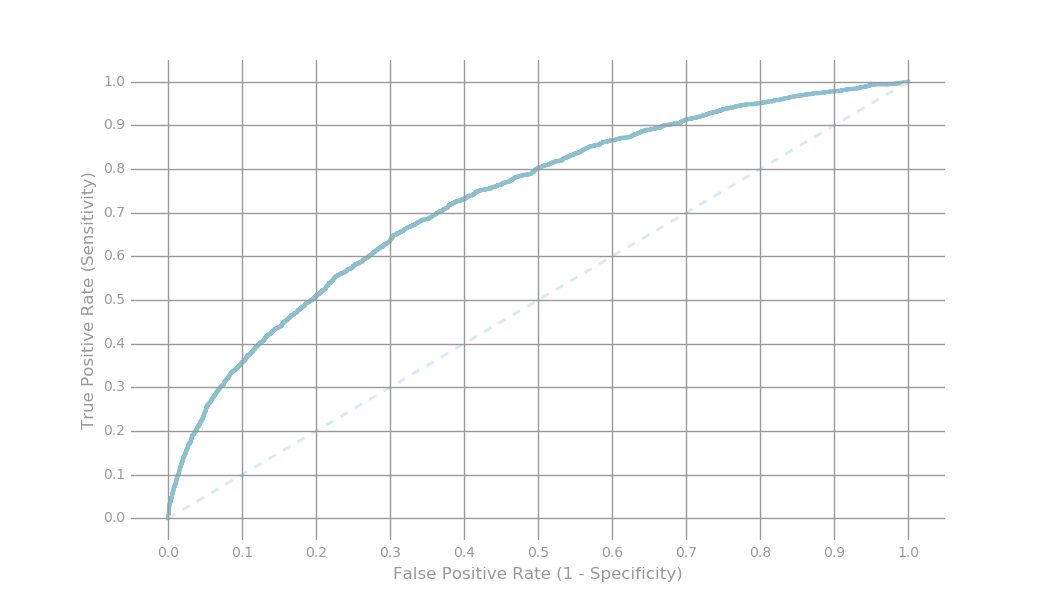

In [83]:
labels_and_scores = add_probability_model_basic(ohe_validation_df).select('label', 'p')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda (k, v): v, reverse=True)
labels_by_weight = np.array([k for (k, v) in labels_and_weights])

length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)

# Generate layout and plot data
fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
display(fig)

## Part 5: Reduce feature dimension via feature hashing

### (5a) Hash function

As we just saw, using a one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed 233K categories in the training data in Part (3c).  Moreover, the full Kaggle training dataset includes more than 33M distinct categories, and the Kaggle dataset itself is just a small subset of Criteo's labeled data.  Hence, featurizing via a one-hot-encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use feature hashing.

Below is the hash function that we will use for this part of the notebook.  We will first use this hash function with the three sample data points from Part (1a) to gain some intuition.  Specifically, run code to hash the three sample points using two different values for `numBuckets` and observe the resulting hashed feature dictionaries.

In [86]:
from collections import defaultdict
import hashlib

def hash_function(raw_feats, num_buckets, print_mapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use print_mapping=True for debug purposes and to better understand how the hashing works.

    Args:
        raw_feats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        num_buckets (int): Number of buckets to use as features.
        print_mapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = { category + ':' + str(ind):
                int(int(hashlib.md5(category + ':' + str(ind)).hexdigest(), 16) % num_buckets)
                for ind, category in raw_feats}
    if(print_mapping): print mapping

    def map_update(l, r):
        l[r] += 1.0
        return l

    sparse_features = reduce(map_update, mapping.values(), defaultdict(float))
    return dict(sparse_features)

# Reminder of the sample values:
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [87]:
# TODO: Replace <FILL IN> with appropriate code
# Use four buckets
samp_one_four_buckets = hash_function(sample_one, 4, True)
samp_two_four_buckets = hash_function(sample_two, 4, True)
samp_three_four_buckets = hash_function(sample_three, 4, True)

# Use one hundred buckets
samp_one_hundred_buckets = hash_function(sample_one, 100, True)
samp_two_hundred_buckets = hash_function(sample_two, 100, True)
samp_three_hundred_buckets = hash_function(sample_three, 100, True)

print '\n\t\t 4 Buckets \t\t\t 100 Buckets'
print 'SampleOne:\t {0}\t\t\t {1}'.format(samp_one_four_buckets, samp_one_hundred_buckets)
print 'SampleTwo:\t {0}\t\t {1}'.format(samp_two_four_buckets, samp_two_hundred_buckets)
print 'SampleThree:\t {0}\t {1}'.format(samp_three_four_buckets, samp_three_hundred_buckets)

{'mouse:0': 3, 'black:1': 3}
{'mouse:2': 1, 'tabby:1': 0, 'cat:0': 1}
{'bear:0': 2, 'black:1': 3, 'salmon:2': 0}
{'mouse:0': 99, 'black:1': 51}
{'mouse:2': 9, 'tabby:1': 72, 'cat:0': 21}
{'bear:0': 82, 'black:1': 51, 'salmon:2': 80}

 4 Buckets 100 Buckets
SampleOne: {3: 2.0} {99: 1.0, 51: 1.0}
SampleTwo: {0: 1.0, 1: 2.0} {72: 1.0, 9: 1.0, 21: 1.0}
SampleThree: {0: 1.0, 2: 1.0, 3: 1.0} {80: 1.0, 82: 1.0, 51: 1.0}

In [88]:
# TEST Hash function (5a)
Test.assertEquals(samp_one_four_buckets, {3: 2.0}, 'incorrect value for samp_one_four_buckets')
Test.assertEquals(samp_three_hundred_buckets, {80: 1.0, 82: 1.0, 51: 1.0},
                  'incorrect value for samp_three_hundred_buckets')

1 test passed.
1 test passed.

### (5b) Creating hashed features

Next we will use this hash function to create hashed features for our CTR datasets. Use the provided UDF to create a function that takes in a DataFrame and returns labels and hashed features.  Then use this function to create new training, validation and test datasets with hashed features.

In [90]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.mllib.linalg import Vectors
num_hash_buckets = 2 ** 15

# UDF that returns a vector of hashed features given an Array of tuples
tuples_to_hash_features_udf = udf(lambda x: Vectors.sparse(num_hash_buckets, hash_function(x, num_hash_buckets)), VectorUDT())

def add_hashed_features(df):
    """Return a DataFrame with labels and hashed features.

    Note:
        Make sure to cache the DataFrame that you are returning.

    Args:
        df (DataFrame with 'tuples' column): A DataFrame containing the tuples to be hashed.

    Returns:
        DataFrame: A DataFrame with a 'label' column and a 'features' column that contains a
            SparseVector of hashed features.
    """
    return df.select([df.label, tuples_to_hash_features_udf(df.feature).alias('features')])

hash_train_df = add_hashed_features(parsed_train_df)
hash_validation_df = add_hashed_features(parsed_validation_df)
hash_test_df = add_hashed_features(parsed_test_df)

hash_train_df.show()

+-----+--------------------+
label| features|
+-----+--------------------+
 0.0|(32768,[1613,1659...|
 0.0|(32768,[274,590,1...|
 0.0|(32768,[1408,1613...|
 0.0|(32768,[1613,2034...|
 0.0|(32768,[1408,1572...|
 0.0|(32768,[1408,1613...|
 0.0|(32768,[1408,1613...|
 0.0|(32768,[1613,1659...|
 0.0|(32768,[1408,1613...|
 0.0|(32768,[1613,2034...|
 0.0|(32768,[274,1613,...|
 0.0|(32768,[400,1443,...|
 0.0|(32768,[1027,1613...|
 0.0|(32768,[1613,2034...|
 0.0|(32768,[340,1408,...|
 0.0|(32768,[1408,2034...|
 0.0|(32768,[1408,1613...|
 0.0|(32768,[1613,2034...|
 0.0|(32768,[1613,1659...|
 0.0|(32768,[300,1613,...|
+-----+--------------------+
only showing top 20 rows

In [91]:
# TEST Creating hashed features (5b)
hash_train_df_feature_sum = sum(hash_train_df
                                  .rdd
                                  .map(lambda r: sum(r[1].indices))
                                  .take(10))
hash_validation_df_feature_sum = sum(hash_validation_df
                                       .rdd
                                       .map(lambda r: sum(r[1].indices))
                                       .take(10))
hash_test_df_feature_sum = sum(hash_test_df
                                 .rdd
                                 .map(lambda r: sum(r[1].indices))
                                 .take(10))

expected_train_sum = 6499660
Test.assertEquals(hash_train_df_feature_sum, expected_train_sum,
                  'incorrect number of features in hash_train_df. Got {0}, expected {1}'.format(hash_train_df_feature_sum, expected_train_sum))

expected_validation_sum = 6725232
Test.assertEquals(hash_validation_df_feature_sum, expected_validation_sum,
                  'incorrect number of features in hash_validation_df. Got {0}, expected {1}'.format(hash_validation_df_feature_sum, expected_validation_sum))

expected_test_sum = 6885806
Test.assertEquals(hash_test_df_feature_sum, expected_test_sum, 'incorrect number of features in hash_test_df. Got {0}, expected {1}'.format(hash_test_df_feature_sum, expected_test_sum))

1 test passed.
1 test passed.
1 test passed.

### (5c) Sparsity

Since we have 33K hashed features versus 233K OHE features, we should expect OHE features to be sparser. Verify this hypothesis by computing the average sparsity of the OHE and the hashed training datasets.

Note that if you have a `SparseVector` named `sparse`, calling `len(sparse)` returns the total number of features, not the number features with entries.  `SparseVector` objects have the attributes `indices` and `values` that contain information about which features are nonzero.  Continuing with our example, these can be accessed using `sparse.indices` and `sparse.values`, respectively.

In [93]:
# TODO: Replace <FILL IN> with appropriate code
def vector_feature_sparsity(sparse_vector):
    """Calculates the sparsity of a SparseVector.

    Args:
        sparse_vector (SparseVector): The vector containing the features.

    Returns:
        float: The ratio of features found in the vector to the total number of features.
    """
    return float(len(sparse_vector.indices))/float(len(sparse_vector))

feature_sparsity_udf = udf(vector_feature_sparsity, DoubleType())

a_sparse_vector = Vectors.sparse(5, {0: 1.0, 3: 1.0})
a_sparse_vector_sparsity = vector_feature_sparsity(a_sparse_vector)
print 'This vector should have sparsity 2/5 or .4.'
print 'Sparsity = {0:.2f}.'.format(a_sparse_vector_sparsity)

This vector should have sparsity 2/5 or .4.
Sparsity = 0.40.

In [94]:
# TEST Sparsity (5c)
Test.assertEquals(a_sparse_vector_sparsity, .4,
                'incorrect value for a_sparse_vector_sparsity')

1 test passed.

### (5d) Sparsity continued

Now that we have a function to calculate vector sparsity, we'll wrap it in a UDF and apply it to an entire DataFrame to obtain the average sparsity for features in that DataFrame.  We'll use the function to find the average sparsity of the one-hot-encoded training DataFrame and of the hashed training DataFrame.

In [96]:
# TODO: Replace <FILL IN> with appropriate code
feature_sparsity_udf = udf(vector_feature_sparsity, DoubleType())

def get_sparsity(df):
    """Calculates the average sparsity for the features in a DataFrame.

    Args:
        df (DataFrame with 'features' column): A DataFrame with sparse features.

    Returns:
        float: The average feature sparsity.
    """
    df = df.select(feature_sparsity_udf(df.features).alias('sparsity'))
    return float(df.select(mean('sparsity')).first()[0])
      
average_sparsity_ohe = get_sparsity(ohe_train_df)
average_sparsity_hash = get_sparsity(hash_train_df)

print 'Average OHE Sparsity: {0:.7e}'.format(average_sparsity_ohe)
print 'Average Hash Sparsity: {0:.7e}'.format(average_sparsity_hash)

Average OHE Sparsity: 1.6670870e-04
Average Hash Sparsity: 1.1896630e-03

In [97]:
# TEST Sparsity (5d)
expected_ohe = 1.6670941e-04
Test.assertTrue(np.allclose(average_sparsity_ohe, expected_ohe),
                'incorrect value for average_sparsity_ohe. Got {0}, expected {1}'.format(average_sparsity_ohe, expected_ohe))
expected_hash = 1.1896565e-03
Test.assertTrue(np.allclose(average_sparsity_hash, expected_hash),
                'incorrect value for average_sparsity_hash. Got {0}, expected {1}'.format(average_sparsity_hash, expected_hash))

1 test passed.
1 test passed.

### (5e) Logistic model with hashed features

Now let's train a logistic regression model using the hashed training features. Use the hyperparameters provided, fit the model, and then evaluate the log loss on the training set.

In [99]:
# TODO: Replace <FILL IN> with appropriate code
standardization = False
elastic_net_param = 0.7
reg_param = .001
max_iter = 20

lr_hash = (LogisticRegression(maxIter=max_iter, regParam=reg_param, elasticNetParam=elastic_net_param, standardization=standardization))

lr_model_hashed = lr_hash.fit(hash_train_df)
print 'intercept: {0}'.format(lr_model_hashed.intercept)
print len(lr_model_hashed.coefficients)

log_loss_train_model_hashed = evaluate_results(hash_train_df, lr_model_hashed)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\thashed = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_hashed))

intercept: -1.24017184805
32768
OHE Features Train Logloss:
	Baseline = 0.535
	hashed = 0.465

In [100]:
# TEST Logistic model with hashed features (5e)
expected =  0.46545524487
Test.assertTrue(np.allclose(log_loss_train_model_hashed, expected),
                'incorrect value for log_loss_train_model_hashed. Got {0}, expected {1}'.format(log_loss_train_model_hashed, expected))

1 test passed.

### (5f) Evaluate on the test set

Finally, evaluate the model from Part (5e) on the test set.  Compare the resulting log loss with the baseline log loss on the test set, which can be computed in the same way that the validation log loss was computed in Part (4f).

In [102]:
# TODO: Replace <FILL IN> with appropriate code
# Log loss for the best model from (5e)
log_loss_test = evaluate_results(hash_test_df, lr_model_hashed)

# Log loss for the baseline model
#class_one_frac_test = float(hash_train_df.select(mean(hash_train_df.label)).first()[0])
print 'Class one fraction for test data: {0}'.format(class_one_frac_test)
log_loss_test_baseline = evaluate_results(hash_test_df, None, class_one_frac_train)

print ('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_test_baseline, log_loss_test))

Class one fraction for test data: 0.226209184564
Hashed Features Test Log Loss:
	Baseline = 0.530
	LogReg = 0.459

In [103]:
# TEST Evaluate on the test set (5f)
expected_test_baseline = 0.530363901139
Test.assertTrue(np.allclose(log_loss_test_baseline, expected_test_baseline),
                'incorrect value for log_loss_test_baseline. Got {0}, expected {1}'.format(log_loss_test_baseline, expected_test_baseline))
expected_test = 0.458838771351
Test.assertTrue(np.allclose(log_loss_test, expected_test),
                'incorrect value for log_loss_test. Got {0}, expected {1}'.format(log_loss_test, expected_test))

1 test failed. incorrect value for log_loss_test_baseline. Got 0.53039824893, expected 0.530363901139
1 test passed.

## Part 6: Cleanup

To avoid exceeding disk storage quotas on Databricks Community Edition, run the following cell to remove the Criteo data file you downloaded earlier.

In [105]:
downloaded_data_file = None
raw_df = None
cleanup_old_downloads()